In [1]:
from ase.io import read, write
from ase import Atoms
from ase.visualize import view
import numpy as np
from mbpol_calculator import MbpolCalculator
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
path = []

for j, k in enumerate([0,10,20,30,40]):
    path.append([])
    template = read('../data/MB-pol/16p16.xyz', index=k)
    start = Atoms('16(OHH)')
    start.set_positions(template.get_positions()[:16*3])

    # view(start)

    a = 0.5

    x = y = -.5*a
    step_size = 0.05


    new_atoms = Atoms(start)
    pos = new_atoms.get_positions()
    pos[:3] += np.array([x, y, 0]).reshape(1,3)
    new_atoms.set_positions(pos)
    path[j].append(new_atoms)

    for i in range(4):
        dx = [1,0,-1,0]
        dy = [0,1,0,-1]

        for dr in np.arange(0,1,step_size):
            new_atoms = Atoms(start)
            pos = new_atoms.get_positions()
            x += dx[i]*a*step_size
            y += dy[i]*a*step_size
            pos[:3] += np.array([x, y, 0]).reshape(1,3)
            new_atoms.set_positions(pos)
#             print(j)
            path[j].append(new_atoms)
        

In [3]:
view(path[0])

In [4]:
work = []
positions = []
all_forces = []
for j, p in enumerate(path):
    work.append([])
    for i, p_ in enumerate(p[:-1]):
        new_atoms = Atoms(start)
        new_atoms.set_positions((p[i+1].get_positions() + p[i].get_positions())*.5)
        forces = MbpolCalculator(new_atoms).get_forces(new_atoms)
        all_forces.append(forces)
        positions.append(new_atoms.get_positions())
        dr = p[i+1].get_positions() - p[i].get_positions()
        work[j].append(np.diag(forces.dot(dr.T)))

In [5]:
np.sum(np.sum(np.array(work), axis =1), axis = -1)

array([-1.08154033e-04, -1.08149686e-04,  1.27640733e-05, -9.49089862e-06,
        1.16803910e-04])

In [8]:
forces_pbe_all = np.genfromtxt('./e_cons_data/forces.dat', delimiter = ',').reshape(5,-1,16*3,3)

In [9]:
work_pbe = []
for j, (p ,forces_pbe)in enumerate(zip(path,forces_pbe_all)):
    work_pbe.append([])
    for i, p_ in enumerate(p[:-1]):
        forces = forces_pbe[i]
        dr = p[i+1].get_positions() - p[i].get_positions()
        work_pbe[j].append(np.diag(forces.dot(dr.T)))

In [10]:
work_pbe

[[array([-0.01456405,  0.0119408 ,  0.01820438,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ]),
  array([-0.0148614 ,  0.01172017,  0.01789393,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
          0.        ,  0.        ,  0.        ,  0.        ,  

In [11]:
np.sum(np.sum(work_pbe, axis =1), axis = -1)

array([ 3.5250e-05,  3.9100e-05,  9.8825e-05, -1.0050e-05,  2.7850e-05])

In [12]:
import mlc_func as mlcf

Using TensorFlow backend.


In [13]:
force_model = {spec : mlcf.ml.load_force_model('../../elf_models/mlcf_master/16p16/pbedz_mbp/',spec)\
               for spec in ['o','h']}

/home/sebastian/miniconda3/lib/python3.6/site-packages/sklearn/base.py:311: UserWarning: Trying to unpickle estimator StandardScaler from version 0.20.0 when using version 0.19.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [14]:
correction_o_all = force_model['o'].predict_from_hdf5('./e_cons_data/basis_nocore_nn.json_processed/conservation_processed.hdf5')
correction_h_all = force_model['h'].predict_from_hdf5('./e_cons_data/basis_nocore_nn.json_processed/conservation_processed.hdf5')

{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}
{'r_o_o': 1.0, 'r_i_o': 0.0, 'r_i_h': 0.0, 'r_o_h': 1.5, 'n_rad_o': 2, 'n_rad_h': 2, 'n_l_o': 3, 'n_l_h': 2, 'gamma_o': 0, 'gamma_h': 0, 'alignment': 'nn'}


In [15]:
correction_o_all = correction_o_all.reshape(5,-1,16,3)
correction_h_all = correction_h_all.reshape(5,-1,16*2,3)

In [16]:
work_mlcf = []
forces_corrected = []
for j, (p,correction_o, correction_h, forces_pbe) in enumerate(zip(path,correction_o_all, correction_h_all,
                                                                  forces_pbe_all)):
    work_mlcf.append([])
    for i, p_ in enumerate(p[:-1]):
        forces = np.array(forces_pbe[i])
        forces[::3] += correction_o[i]
        forces[1::3] += correction_h[i][::2]
        forces[2::3] += correction_h[i][1::2]
        forces_corrected.append(forces)
        dr = p[i+1].get_positions() - p[i].get_positions()
        work_mlcf[j].append(np.diag(forces.dot(dr.T)))

In [17]:
np.sum(np.sum(work_mlcf, axis =1), axis = -1)

array([ 0.00057204,  0.01697764, -0.00734381, -0.01686716,  0.01695571])

In [18]:
work_mlcf =np.array(work_mlcf)
work = np.array(work)
work_pbe = np.array(work_pbe)

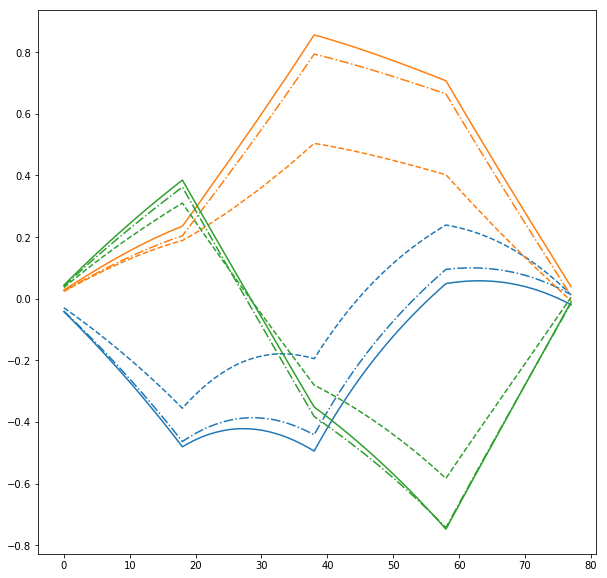

In [19]:
figsize(10,10)
for i in range(3):
    plot([np.sum(np.array(work_mlcf)[0,:j,i]) for j in np.arange(2,np.array(work_mlcf).shape[1],1)], 
         color = 'C{}'.format(i))
    plot([np.sum(np.array(work_pbe)[0,:j,i]) for j in np.arange(2,np.array(work_mlcf).shape[1],1)], 
         color = 'C{}'.format(i), ls ='--')
    plot([np.sum(np.array(work)[0,:j,i]) for j in np.arange(2,np.array(work_mlcf).shape[1],1)], 
         color = 'C{}'.format(i), ls ='-.')

In [35]:
forces_pbe = forces_pbe_all.reshape(5,-1,16*3,3)[:,:,:3].reshape(-1,3)

In [28]:
forces_corrected = np.array(forces_corrected).reshape(5,-1,16*3,3)[:,:,:3].reshape(-1,3)

In [30]:
forces_mbpol = np.array(all_forces).reshape(5,-1,16*3,3)[:,:,:3].reshape(-1,3)

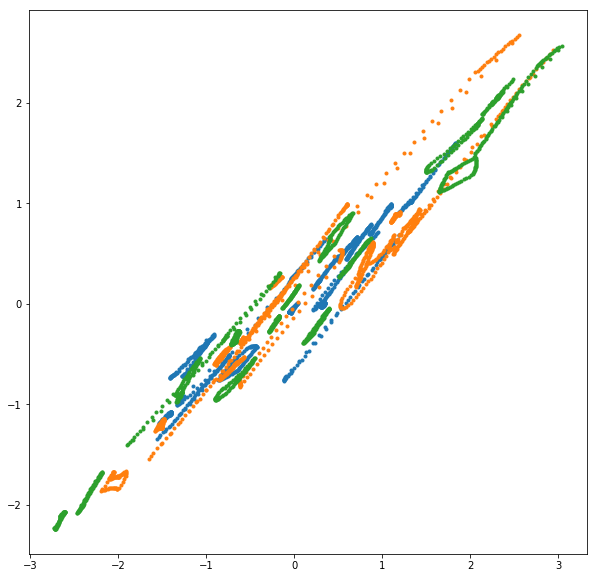

In [37]:
plot(forces_mbpol, forces_pbe, ls = '', marker = '.')

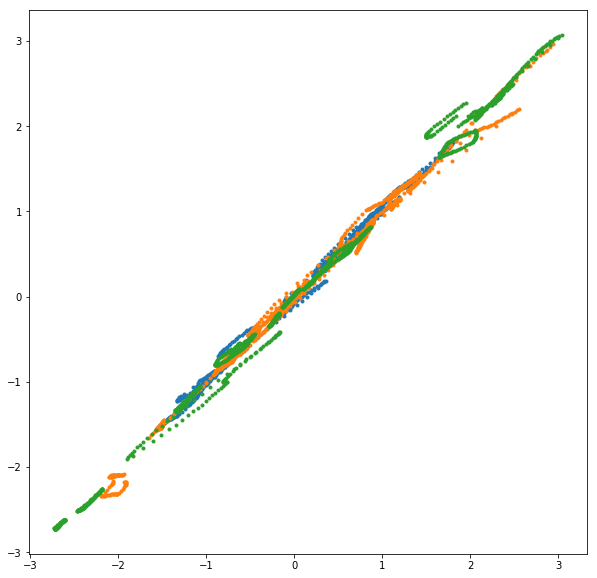

In [38]:
plot(forces_mbpol, forces_corrected, ls = '', marker = '.')

In [39]:
np.sqrt(np.mean((forces_mbpol- forces_corrected)**2))

0.07960611738044161